# Final Project - camera calibration and undistortion

In [79]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [80]:
def onlyOneChessboard(grayImage,type,n):
    """
    Args:
    grayImage (ndarray): grayscale of current image, 
    type (int): number indicating type if checkerboard
    n (int): number indicating number of checkerboard of current type

    Returns:
        image: the checkerboard to look at
    """    
    
    address = 'templates/' + str(type) + '_board_' + str(n) + '.png'
    template = cv2.imread(address)
    template = template[...,0]
    res = cv2.matchTemplate(grayImage, template, cv2.TM_CCORR_NORMED)

    _, _, _, maxLoc = cv2.minMaxLoc(res)
    topLeft = maxLoc
    bottomRight = (topLeft[0] + template.shape[1], topLeft[1] + template.shape[0])
    
    oneChessboard = grayImage
    oneChessboard[0:topLeft[1],...] = 125
    oneChessboard[...,0:topLeft[0]] = 125
    oneChessboard[bottomRight[1]:grayImage.shape[0],...] = 125
    oneChessboard[...,bottomRight[0]:grayImage.shape[1]] = 125
    
    return oneChessboard

In [81]:
def findMultipleChessCorners(nb_horizontal, nb_vertical, nb_board, type, leftImg, rightImg, objpoints, 
                             leftImgPoints, rightImgPoints, time=0, squareSize=100):
    """Function finding chessboard corners of multiple checkerboards
    Args:
        nb_horizontal (int): number of horizontal corners
        nb_vertical (int): number of vertical corners
        nb_board (int): board type number
        type (int): board type
        leftImg (ndarray): left image
        rightImg (ndarray): right image
        objpoints (list): list of object points
        leftImgPoints (list): list of left image points
        rightImgPoints (list): list of right image points
        time (int, optional): time to display the found corners. Defaults to 0.

    Returns:
        objpoints, leftImgPoints, rightImgPoints (list, list, list): 
                            list of object points and two lists of image points 
    """    
    leftWithCorners = leftImg
    rightWithCornes = rightImg
    leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
    rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    for i in range(1,nb_board):
        objp = np.zeros((nb_horizontal*nb_vertical,3), np.float32)
        objp[:,:2] = np.mgrid[0:nb_horizontal,0:nb_vertical].T.reshape(-1,2)
        objp = objp * squareSize        # Coordinates of the squares in the real world (mm)
        # Apply a template to look only at one specific chessboard
        currentLeftGray = onlyOneChessboard(leftGray,type,i)
        currentRightGray = onlyOneChessboard(rightGray,type,i)
        leftGray = cv2.cvtColor(leftImg, cv2.COLOR_BGR2GRAY)
        rightGray = cv2.cvtColor(rightImg, cv2.COLOR_BGR2GRAY)

        leftRet, leftCorners = cv2.findChessboardCornersSB(currentLeftGray, (nb_horizontal,nb_vertical),
                                                         flags=cv2.CALIB_CB_EXHAUSTIVE)
        rightRet, rightCorners = cv2.findChessboardCornersSB(currentRightGray, (nb_horizontal,nb_vertical),
                                                            flags=cv2.CALIB_CB_EXHAUSTIVE)

        # If found in both frames, add object points + image points (after refining them)
        if leftRet == True and rightRet == True:
            objpoints.append(objp)
            leftCorners = cv2.cornerSubPix(currentLeftGray,leftCorners,(5,5),(-1,-1),criteria)
            rightCorners = cv2.cornerSubPix(currentRightGray,rightCorners,(5,5),(-1,-1),criteria)
            leftImgPoints.append(leftCorners)
            rightImgPoints.append(rightCorners)

            # Draw and display the corners if wanted
            if time != 0:
                leftWithCorners = cv2.drawChessboardCorners(leftWithCorners, (nb_horizontal,nb_vertical), 
                                                            leftCorners,leftRet)
                rightWithCornes = cv2.drawChessboardCorners(rightWithCornes, (nb_horizontal,nb_vertical), 
                                                            rightCorners,rightRet)
                # cv2.imshow('Left', leftWithCorners)
                # Show both images side by side
                both = np.concatenate((leftWithCorners, rightWithCornes), axis=0)
                cv2.imshow('Corners', both)
                cv2.waitKey(time)
    
    return objpoints, leftImgPoints, rightImgPoints

In [82]:
def findAllChessCorners(leftImgs, rightImgs, time=0):
    """Function looping through all the left and right images and finding the 
    corners of all the checkerboards

    Args:
        leftImgs (glob): glob pointing to the left images
        rightImgs (glob): glob pointing to the right images
        time (int, optional): time to display the found corners. Defaults to 0.

    Returns:
        objpoints (list): list of all the object points
        leftImgPoints (list): list of all the left image points
        rightImgPoints (list): list of all the right image points
    """    
    objpoints = [] # 3d point in real world space
    leftImgPoints = [] 
    rightImgPoints = [] # 2d points in image plane.
    
    for fname1, fname2 in zip(leftImgs, rightImgs):
        leftImg = cv2.imread(fname1)
        rightImg = cv2.imread(fname2)
        
        # Find the chess board corners for the boards with shape (7,5)
        nb_horizontal = 7
        nb_vertical = 5
        objpoints, leftImgPoints, rightImgPoints = \
            findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     6, 1, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)

        # Find the chess board corners for the boards with shape (5,7)
        nb_horizontal = 5
        nb_vertical = 7
        objpoints, leftImgPoints, rightImgPoints = \
            findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     6, 2, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
        # Find the chess board corners for the boards with shape (11,7)
        nb_horizontal = 11
        nb_vertical = 7
        objpoints, leftImgPoints, rightImgPoints = \
            findMultipleChessCorners(nb_horizontal, nb_vertical, 
                                     3, 3, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
        # Find the chess board corners for the board with shape (5,15)
        nb_horizontal = 5
        nb_vertical = 15
        objpoints, leftImgPoints, rightImgPoints = \
            findMultipleChessCorners(nb_horizontal, nb_vertical,
                                     2, 4, leftImg, rightImg, objpoints, 
                                     leftImgPoints, rightImgPoints, time)
    if time != 0:
        cv2.destroyAllWindows()
    return objpoints, leftImgPoints, rightImgPoints

In [83]:
def undistortAll(images, cameraMatrix, dist, newCameraMatrix, roi, side):
    """
    Function to undistort and crop all images in a folder and save them in a 
    new "undistorted/" folder
    Args:
    images (glob): glob pointing to the images to undistort
    cameraMatrix (ndarray): the camera matrix
    dist (ndarray): distortion coefficients
    newCameraMatrix (ndarray): new refined camera matrix 
    """    
    for fname in images:
        img = cv2.imread(fname)
        undistorted = cv2.undistort(img, cameraMatrix, dist, None, newCameraMatrix)
        x,y,w,h = roi
        undistorted = undistorted[y:y+h, x:x+w]
        cv2.imwrite("final_project_data/undistorted/" + side + "/" + fname.split("/")[-1], undistorted)        

In [84]:
# Load the left and right images
leftImgs = glob.glob("final_project_data/calib/image_02/data/*.png", recursive=True)
rightImgs = glob.glob("final_project_data/calib/image_03/data/*.png", recursive=True)

In [85]:
#NOTE: this takes ~1 min to run with time=100 (0.1 sec per image)
# Obtain the left and right image points, as well as all the object points
objpoints, leftImgPoints, rightImgPoints = findAllChessCorners(leftImgs, rightImgs, time=0)

In [69]:
#NOTE: this takes a while to run (~2.5 minutes)
# Getting left camera matrix
leftImg = cv2.imread('final_project_data/calib/image_02/data/0000000000.png')
leftGray = cv2.imread('final_project_data/calib/image_02/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
h, w = leftGray.shape[:2]
ret, leftCamMatrix, leftCamDist, leftRvecs, leftTvecs = cv2.calibrateCamera(objpoints, leftImgPoints, leftGray.shape[::-1],None,None)
leftCamMatrix, leftRoi = cv2.getOptimalNewCameraMatrix(leftCamMatrix,leftCamDist,(w,h),1,(w,h))

In [70]:
#NOTE: this takes a while to run (~2.5 minutes)
# Getting right camera matrix
rightImg = cv2.imread('final_project_data/calib/image_03/data/0000000000.png')
rightGray = cv2.imread('final_project_data/calib/image_03/data/0000000000.png', cv2.IMREAD_GRAYSCALE)
h, w = rightImg.shape[:2]
ret, rightCamMatrix, rightCamDist, rightRvecs, rightTvecs = cv2.calibrateCamera(objpoints, rightImgPoints, rightGray.shape[::-1], None, None)
rightCamMatrix, rightRoi = cv2.getOptimalNewCameraMatrix(rightCamMatrix,rightCamDist,(w,h),1,(w,h))

In [71]:
# Stereo calibrate the cameras using the two optimal camera matrices from above
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001) # termination criteria

ret, leftCamMatrix, leftCamDist, rightCamMatrix, rightCamDist, R, T, E, F = \
        cv2.stereoCalibrate(objpoints, leftImgPoints, rightImgPoints, leftCamMatrix, 
                            leftCamDist, rightCamMatrix, rightCamDist, leftGray.shape[::-1], 
                            criteria = criteria, flags = cv2.CALIB_FIX_INTRINSIC)

### Source: https://learnopencv.com/making-a-low-cost-stereo-camera-using-opencv/#stereo-rectification

In [72]:
# Stereo rectify the images to have them be in the same plane
rectifiedLeft, rectifiedRight, projectionLeft, projectionRight, Q, roiLeft, roiRight=\
    cv2.stereoRectify(leftCamMatrix, leftCamDist, rightCamMatrix, rightCamDist,
                      leftGray.shape[::-1], R, T)

In [73]:
leftStereoMapX, leftStereoMapY = cv2.initUndistortRectifyMap(leftCamMatrix, leftCamDist, 
                                                             rectifiedLeft, projectionLeft, 
                                                             leftGray.shape[::-1], cv2.CV_16SC2)
rightStereoMapX, rightStereoMapY = cv2.initUndistortRectifyMap(rightCamMatrix, rightCamDist,
                                                                rectifiedRight, projectionRight, 
                                                                rightGray.shape[::-1], cv2.CV_16SC2)
# Save the parameters to an xml file 
cv_file = cv2.FileStorage("stereoCamParameters.xml", cv2.FILE_STORAGE_WRITE)
cv_file.write("Left_Stereo_Map_x",leftStereoMapX)
cv_file.write("Left_Stereo_Map_y",leftStereoMapY)
cv_file.write("Right_Stereo_Map_x",rightStereoMapX)
cv_file.write("Right_Stereo_Map_y",rightStereoMapY)
cv_file.release()

# From here, undistortion and remapping should happen
ref: https://learnopencv.com/depth-perception-using-stereo-camera-python-c/ 

To avoid running the above code again, simply fetch the saved stereo maps from the file!


Difference between calibrating each camera individually vs stereo calibration; https://stackoverflow.com/questions/71699988/difference-between-stereo-camera-calibration-vs-two-single-camera-calibrations-u 

TL;DR - single camera gives intrinsics only, whilst cv2.stereoCalibrate gives extrinsics as well, for depth estimation etc

**NOTE:** can the two functions below be replaced by simply cv2.undiort() like above?
ref: https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html#:~:text=1.%20Using%20cv.undistort()

In [ ]:
# Fetch the saved parameters from earlier (if you don't want to run the above code which takes ages)
# TODO

In [76]:
# Rectify the two images
rectifiedLeft = cv2.remap(leftGray, leftStereoMapX, leftStereoMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)
rectifiedRight = cv2.remap(rightGray, rightStereoMapX, rightStereoMapY, cv2.INTER_LINEAR, cv2.BORDER_CONSTANT)

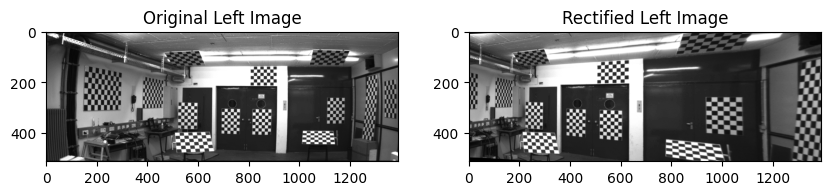

In [78]:
# Display the left recitified image next to the original left image
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(leftGray, cmap='gray')
plt.title("Original Left Image")
plt.subplot(122)
plt.imshow(rectifiedLeft, cmap='gray')
plt.title("Rectified Left Image")
plt.show()

# TO DO
Verify the results! 